In [1]:
import requests
import pandas as pd
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import os
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import transforms
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms.functional as TF
import math
import random
import statistics
import glob
import concurrent.futures
import gc
from datetime import datetime

In [ ]:
test

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.7


In [2]:
# Retrieve census data for specified location(s) and geography type (e.g., block group)

# Replace YOUR_API_KEY_HERE with your own API key
API_KEY = "bd041cbc149095f7871a9d002c6ca41d7b8010ef"

# Define the API endpoint
url = "https://api.census.gov/data/{year}/acs/acs5"

# Define the variables and geography of interest
variables = "B19013_001E"
geography = "block group:*"

# Read the CSV file
metadata_df = pd.read_csv("../data/output/downloaded_scenes_metadata.csv")

# Filter the metadata for the desired cities
cities = ["new_york", "chicago", "los_angeles"]
filtered_metadata_df = metadata_df[metadata_df["city"].isin(cities)]

# Initialize an empty list to store the results
dfs = []

# Loop over each city in the filtered metadata DataFrame
for city in cities:
    # Get the first row for the city
    city_row = filtered_metadata_df[filtered_metadata_df["city"] == city].iloc[0]

    year = city_row["year"]
    print(f'{city}: {year}')

    # Define the location of interest
    if city == "new_york":
        location = "state:36+county:005,047,061,081,085+tract:*"
    elif city == "chicago":
        location = "state:17+county:031+tract:*"
    elif city == "los_angeles":
        location = "state:06+county:037+tract:*"

    # Build the API query
    query = f"{url.format(year=year)}?get={variables}&for={geography}&in={location}&key={API_KEY}"

    # Make the API call
    response = requests.get(query)

    # Parse the response as JSON
    data = response.json()

    # Convert the list to a DataFrame
    temp_df = pd.DataFrame(data[1:], columns=data[0])

    # Append the temporary DataFrame to the list
    dfs.append(temp_df)

# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

# Display the DataFrame
df


new_york: 2021
chicago: 2021
los_angeles: 2020


,B19013_001E,state,county,tract,block group
0,-666666666,36,005,000100,0
1,-666666666,36,005,000100,1
2,-666666666,36,005,000200,0
3,-666666666,36,005,000200,1
4,72232,36,005,000200,2
...,...,...,...,...,...
17395,124010,06,037,117404,1
17396,117381,06,037,117404,2
17397,101790,06,037,117404,3
17398,41290,06,037,117405,1


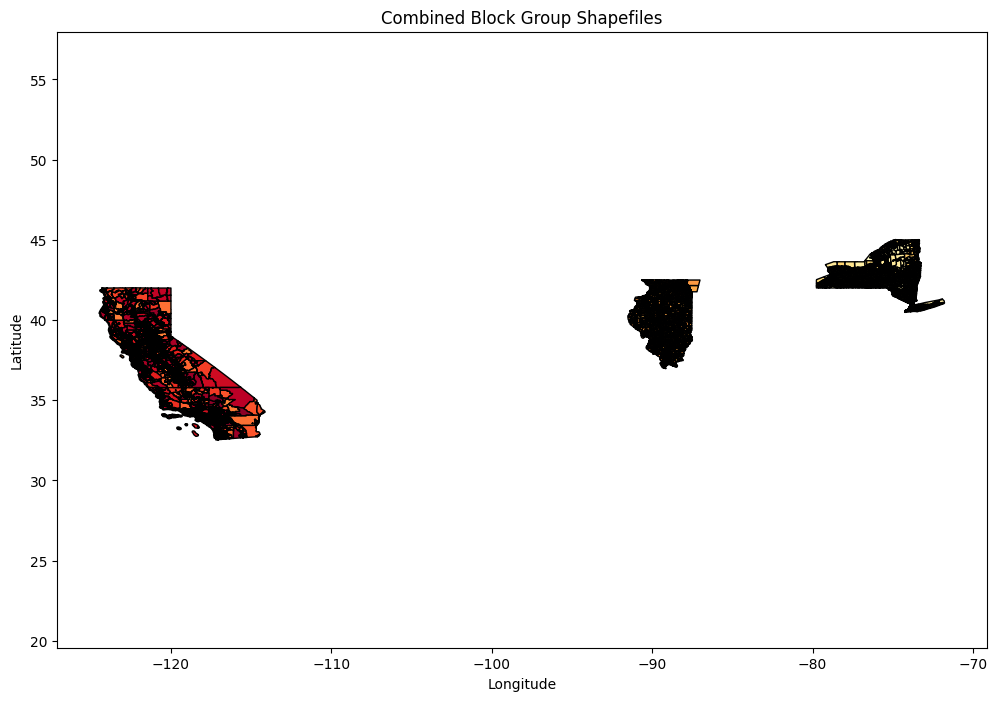

In [3]:
## Unzip and show block group shapefiles

# Path to the directory containing the ZIP files
zip_directory = "../data/state_block_group_shapefiles/"

# Get a list of all ZIP files in the directory
zip_files = glob.glob(zip_directory + "*.zip")

# Create an empty list to store the GeoDataFrame objects
gdf_list = []

# Loop over each ZIP file
for zip_file in zip_files:
    # Get the name of the extracted shapefile
    shapefile_name = zip_file.replace(".zip", ".shp")

    # Check if the shapefile has already been extracted
    if not os.path.exists(shapefile_name):
        # Extract the shapefile from the zip archive
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(zip_directory)

    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile_name)

    # Append the current GeoDataFrame to the list
    gdf_list.append(gdf)

# Combine all GeoDataFrame objects into a single GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

# Plot the combined GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 8))
combined_gdf.plot(ax=ax, cmap='YlOrRd', edgecolor='k')

# Customize the plot appearance
ax.set_title("Combined Block Group Shapefiles")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.axis('equal')

# Display the plot
plt.show()


In [4]:
# merge census API and shapefile dataframes, drop N/A values, and sort

# Merge the shapefile and API dataframes
merged_df = pd.merge(combined_gdf, df, left_on=['BLKGRPCE', 'TRACTCE', 'COUNTYFP', 'STATEFP'], right_on=['block group', 'tract', 'county', 'state'], how='inner')

# Drop N/A values in the median household income column
merged_df['B19013_001E'] = pd.to_numeric(merged_df['B19013_001E'], errors='coerce')
merged_df = merged_df[merged_df['B19013_001E'] != -666666666]

# Sort the dataframe by median household income in descending order
merged_df = merged_df.sort_values(by='B19013_001E', ascending=False)

# Display the merged and sorted dataframe
pd.set_option('display.max_rows', False)
print(merged_df[['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'B19013_001E', 'geometry']])

      STATEFP COUNTYFP TRACTCE BLKGRPCE  B19013_001E   
16128      06      037  269700        3       250001  \
3877       36      061  017900        6       250001   
1109       36      061  002100        4       250001   
5370       36      061  014500        1       250001   
12453      06      037  188202        2       250001   
5372       36      061  014601        1       250001   
1117       36      061  009901        1       250001   
8035       17      031  081202        1       250001   
8936       17      031  080400        3       250001   
...       ...      ...     ...      ...          ...   
8473       17      031  400800        2         9320   
1001       36      005  002702        4         9208   
3948       36      005  044200        4         6152   
14877      06      037  206303        1         4918   
12678      06      037  297202        3         2499   
8992       17      031  825503        3         2499   
8626       17      031  420700        4         

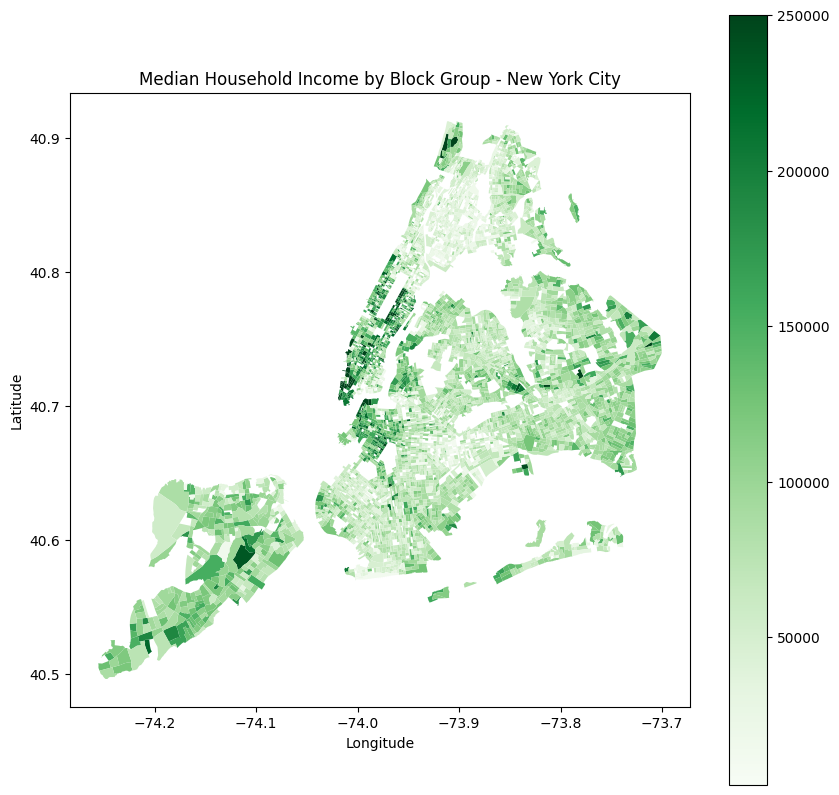

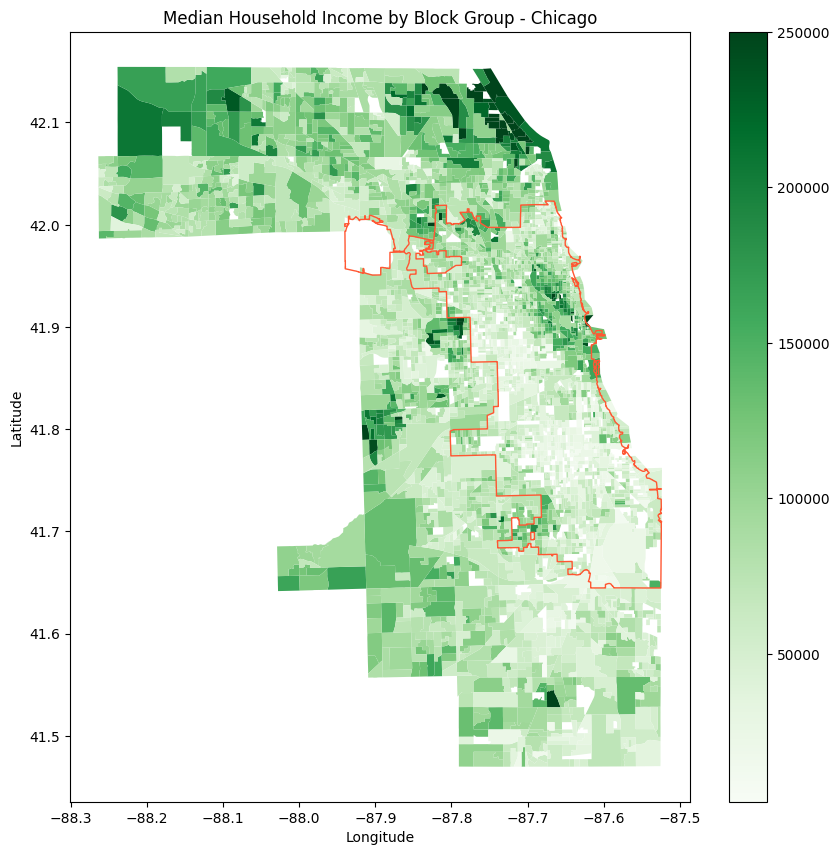

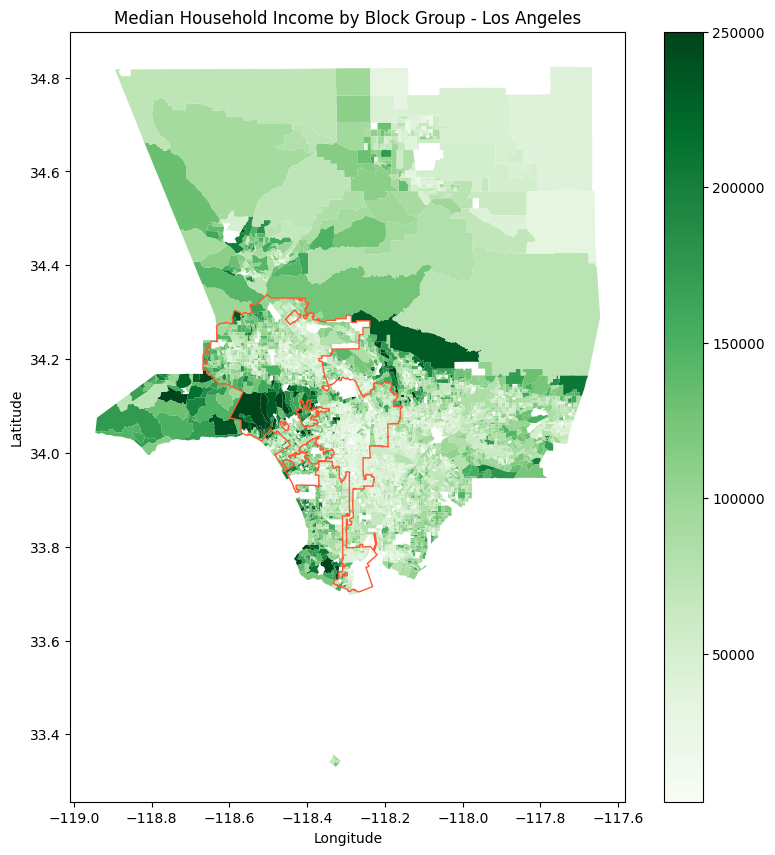

In [17]:
## Show heat map of block groups by median household income

# # Extract city boundaries from zip files 
# with zipfile.ZipFile('../data/city_boundaries/Chicago_Boundary.zip', 'r') as zip_ref:
#     zip_ref.extractall('../data/city_boundaries/Chicago/')
    
# with zipfile.ZipFile('../data/city_boundaries/LA_Boundary.zip', 'r') as zip_ref:
#     zip_ref.extractall('../data/city_boundaries/LA/')

# Load the shapefiles containing city boundaries
chicago_boundary = gpd.read_file('../data/city_boundaries/Chicago/')
la_boundary = gpd.read_file('../data/city_boundaries/LA/')

# Convert the DataFrame to a GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Filter data for New York Counties (based on state)
ny_gdf = merged_gdf[merged_gdf['STATEFP'] == '36']

# Create a choropleth map for New York City
fig, ax = plt.subplots(figsize=(10, 10))
ny_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
ax.set_title('Median Household Income by Block Group - New York City')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Filter data for Cook County (based on state)
ill_gdf = merged_gdf[merged_gdf['STATEFP'] == '17']

# Create a choropleth map for Cook County with Chicago city boundary
fig, ax = plt.subplots(figsize=(10, 10))
ill_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
chicago_boundary.plot(ax=ax, color='none', edgecolor='#FF5733', linewidth=1)
ax.set_title('Median Household Income by Block Group - Chicago')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Filter data for LA County (based on state)
ca_gdf = merged_gdf[merged_gdf['STATEFP'] == '06']

# Create a choropleth map for LA County with Los Angeles city boundary
fig, ax = plt.subplots(figsize=(10, 10))
ca_gdf.plot(column='B19013_001E', cmap='Greens', ax=ax, legend=True)
la_boundary.plot(ax=ax, color='none', edgecolor='#FF5733', linewidth=1)
ax.set_title('Median Household Income by Block Group - Los Angeles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [26]:
# crop the block groups from NAIP tiffs and save

# Convert the geometry column in csv_df to Shapely Polygon objects
metadata_gdf = gpd.GeoDataFrame(metadata_df, geometry=metadata_df['geometry'].apply(shapely.wkt.loads), crs="EPSG:4326")

# Create a spatial index for the CSV file
metadata_gdf.sindex

# Define the path for the output cropped tiffs
output_folder = '../data/crops'

# Iterate over each row in merged_gdf
for idx, row in merged_gdf.iloc[:].iterrows():

    # Get the bounding box of the merged_gdf geometry
    bbox = row.geometry.bounds

    # Query the spatial index to get potential matches
    potential_matches = list(metadata_gdf.sindex.intersection(bbox))

    # Filter the potential matches to those that fully contain the merged_gdf geometry
    matches = []
    for i in potential_matches:
        if metadata_gdf.loc[i, 'geometry'].contains(row.geometry):
            matches.append(i)

    # If there is a match, crop the tiff and save it
    if len(matches) > 0:
        tif_filename = metadata_gdf.loc[matches[0], 'tif_filename']
        STATEFP = merged_gdf.loc[idx, 'STATEFP']
        COUNTYFP = merged_gdf.loc[idx, 'COUNTYFP']
        TRACTCE = merged_gdf.loc[idx, 'TRACTCE']
        BLKGRPCE = merged_gdf.loc[idx, 'BLKGRPCE']
        B19013_001E = merged_gdf.loc[idx, 'B19013_001E']
        crop_filename = f"{STATEFP}_{COUNTYFP}_{TRACTCE}_{BLKGRPCE}_{B19013_001E}.tif"
        tif_path = os.path.join('../data/output/unzipped_files', tif_filename)

        with rasterio.open(tif_path, indexes=[1, 2, 3]) as src:

            # Reproject the geometry to match the CRS of the raster
            geometry = gpd.GeoSeries(row.geometry).set_crs("EPSG:4326").to_crs(src.crs).iloc[0]
            # Crop the raster using the reprojected geometry
            out_image, out_transform = mask(src, [geometry], crop=True, indexes=[1, 2, 3])
        
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "count": 3,
                         "transform": out_transform})
        out_path = os.path.join(output_folder, crop_filename)
        
        with rasterio.open(out_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [7]:
## Find largest and median height and width

# Directory path for the crop images
crop_dir = '../data/crops/'

# Initialize variables for maximum width, height, and lists for all widths and heights
max_width = 0
max_height = 0
all_widths = []
all_heights = []

def process_file(filename):
    if filename.endswith('.tif'):  # Consider only TIFF files
        # Get the full path of the image file
        crop_path = os.path.join(crop_dir, filename)

        # Open the cropped image file
        with rasterio.open(crop_path) as src:
            # Get the width and height of the image
            width = src.width
            height = src.height

            return width, height

    return None

# Iterate over files in the crop directory using os.scandir()
with os.scandir(crop_dir) as entries:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for entry in entries:
            if entry.is_file():
                futures.append(executor.submit(process_file, entry.name))

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                width, height = result

                # Update maximum width and height if necessary
                if width > max_width:
                    max_width = width
                if height > max_height:
                    max_height = height

                # Append the width and height to the lists
                all_widths.append(width)
                all_heights.append(height)

# Calculate the median width and height
median_width = statistics.median(all_widths)
median_height = statistics.median(all_heights)

# Calculate the standard deviation of width and height
std_width = statistics.stdev(all_widths)
std_height = statistics.stdev(all_heights)

# Print the largest width, height, median width, median height, standard deviation of width, and standard deviation of height
print('Largest Height:', max_height)
print('Largest Width:', max_width)
print('Median Height:', median_height)
print('Median Width:', median_width)
print('Standard Deviation of Height:', std_height)
print('Standard Deviation of Width:', std_width)

# Get the list of files in the directory
file_list = os.listdir(crop_dir)
# Count the number of files
num_files = len(file_list)
# Print the number of files
print("Number of images:", num_files)

Largest Height: 8607
Largest Width: 8943
Median Height: 714
Median Width: 710
Standard Deviation of Height: 577.0258871891327
Standard Deviation of Width: 581.10772319438
Number of images: 11639


CRS: EPSG:26916
Bands: 3
Width: 1477
Height: 2027
Bounds: BoundingBox(left=452149.8, bottom=4617519.0, right=453036.0, top=4618735.2)
Transform: | 0.60, 0.00, 452149.80|
| 0.00,-0.60, 4618735.20|
| 0.00, 0.00, 1.00|
Data type: uint8


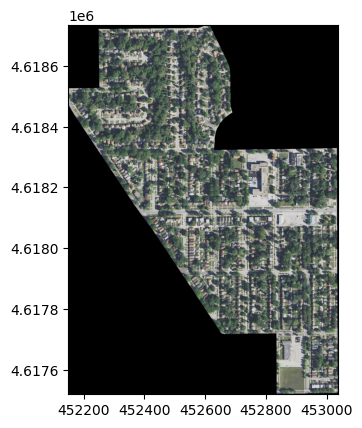

In [8]:
# Display a crop with its metadata

# Get a list of image files in the directory
image_files = os.listdir(crop_dir)

# Select a random image file
random_image_file = random.choice(image_files)

# Define the path to the selected image file
image_path = os.path.join(crop_dir, random_image_file)

# Open the image file
with rasterio.open(image_path) as src:
   
    # print metadata
    print('CRS:', src.crs)
    print('Bands:', src.count)
    print('Width:', src.width)
    print('Height:', src.height)
    print('Bounds:', src.bounds)
    print('Transform:', src.transform)
    print('Data type:', src.dtypes[0])

    # Plot the image
    show(src)

In [9]:
## Method: use entire image (no patches), resizing image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.root_dir, image_name)

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Extract the label from the image name
        label = float(image_name.split('_')[-1].split('.')[0])

        # Apply transformations if provided
        if self.transform is not None:
            image = self.transform(image)

        # Convert image and label to tensors
        image = image.clone().detach().requires_grad_(True).to(torch.float32)
        label = torch.tensor(label, dtype=torch.float32).clone().detach()

        return image, label

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((round(median_height), round(median_width))),
    transforms.ToTensor()
])

# Define the path to the directory containing the image files
data_dir = '../data/crops'

# Set a random seed for reproducibility
random.seed(42)

# Create an instance of the custom dataset
dataset = CustomDataset(data_dir, transform=transform)

# Calculate the sizes for training, validation, and testing sets
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create random indices for splitting the dataset
indices = list(range(dataset_size))
random.shuffle(indices)

# Split the dataset into training, validation, and testing sets
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create the training dataset
train_dataset = torch.utils.data.Subset(dataset, train_indices)

# Create the validation dataset
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Create the testing dataset
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Testing set size:", len(test_dataset))

train_idx = random.randint(0, len(train_dataset) - 1)
train_image, train_label = train_dataset[train_idx]

# Calculate the mean, median, maximum, minimum, and standard deviation of the labels
labels = [data[1] for data in dataset]
mean_label = np.mean(labels)
median_label = np.median(labels)
max_label = np.max(labels)
min_label = np.min(labels)
std_label = np.std(labels)

# Print the calculated statistics
print("Mean label:", mean_label)
print("Median label:", median_label)
print("Maximum label:", max_label)
print("Minimum label:", min_label)
print("Standard deviation of labels:", std_label)

# Example usage:
train_idx = random.randint(0, len(train_dataset) - 1)
train_image, train_label = train_dataset[train_idx]

Training set size: 8147
Validation set size: 1745
Testing set size: 1747
Mean label: 80625.56
Median label: 71250.0
Maximum label: 250001.0
Minimum label: 2499.0
Standard deviation of labels: 44711.21


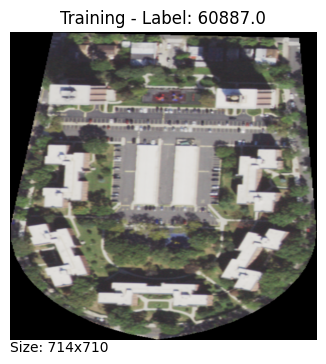

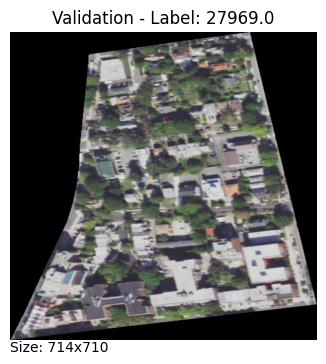

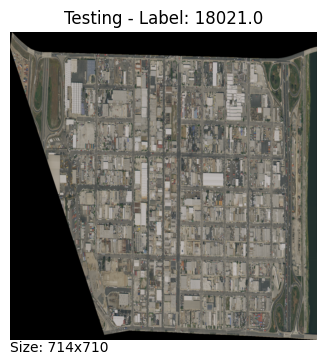

In [10]:
# Select a random image from the training dataset
train_idx = random.randint(0, len(train_dataset) - 1)
train_image, train_label = train_dataset[train_idx]
plt.figure(figsize=(4, 4))
plt.imshow(train_image.permute(1, 2, 0).detach().numpy())
plt.title(f"Training - Label: {train_label}")
plt.axis('off')
plt.text(0, train_image.shape[1], f"Size: {train_image.shape[1]}x{train_image.shape[2]}", fontsize=10, ha='left', va='top')
plt.show()

# Select a random image from the validation dataset
val_idx = random.randint(0, len(val_dataset) - 1)
val_image, val_label = val_dataset[val_idx]
plt.figure(figsize=(4, 4))
plt.imshow(val_image.permute(1, 2, 0).detach().numpy())
plt.title(f"Validation - Label: {val_label}")
plt.axis('off')
plt.text(0, val_image.shape[1], f"Size: {val_image.shape[1]}x{val_image.shape[2]}", fontsize=10, ha='left', va='top')
plt.show()

# Select a random image from the testing dataset
test_idx = random.randint(0, len(test_dataset) - 1)
test_image, test_label = test_dataset[test_idx]
plt.figure(figsize=(4, 4))
plt.imshow(test_image.permute(1, 2, 0).detach().numpy())
plt.title(f"Testing - Label: {test_label}")
plt.axis('off')
plt.text(0, test_image.shape[1], f"Size: {test_image.shape[1]}x{test_image.shape[2]}", fontsize=10, ha='left', va='top')
plt.show()


In [11]:
## Method: resized image (no patches) with ResNet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

# Define ResNet-50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model.fc.in_features

# Add additional fully connected layers
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 224),
    nn.ReLU(inplace=True),
    nn.Linear(224, 32),
    nn.ReLU(inplace=True),
    nn.Linear(32, 1)
)
model.to(device)

# Define loss function
criterion = nn.L1Loss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Create model directory
current_datetime = datetime.now()
model_dir = f'../saved_models/resized/{current_datetime.strftime("%Y-%m-%d_%H-%M-%S")}'
os.makedirs(model_dir)

# Initialize lists to store historical training and validation loss
train_losses = []
val_losses = []

# Initialize variables for tracking best validation accuracy
best_val_loss = float('inf')

# Training loop
num_epochs = 500
patience = 5
no_improvement_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss) # for history

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss) # for history

        # Check for improvement in validation accuracy
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_counter = 0
            history = {'train_losses': train_losses, 'val_losses': val_losses}
            best_model_path = f'{model_dir}/{epoch+1}_{best_val_loss:.0f}.pt'
            torch.save({'model_state_dict': model.state_dict(), 'history': history}, best_model_path)
        else:
            no_improvement_counter += 1

        # Early stopping if no improvement after patience epochs
        if no_improvement_counter >= patience:
            print(f"No improvement in validation loss after {patience} epochs. Training stopped.")
            break

    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.0f}, Val Loss: {val_loss:.0f}")

Epoch 1/500: Train Loss: 37193, Val Loss: 32921
Epoch 2/500: Train Loss: 34323, Val Loss: 79152
Epoch 3/500: Train Loss: 33986, Val Loss: 32273
Epoch 4/500: Train Loss: 33187, Val Loss: 41070
Epoch 5/500: Train Loss: 32840, Val Loss: 31308
Epoch 6/500: Train Loss: 32660, Val Loss: 32679
Epoch 7/500: Train Loss: 32715, Val Loss: 37435
Epoch 8/500: Train Loss: 32175, Val Loss: 29531
Epoch 9/500: Train Loss: 31903, Val Loss: 30352
Epoch 10/500: Train Loss: 32187, Val Loss: 33146
Epoch 11/500: Train Loss: 32296, Val Loss: 33542
Epoch 12/500: Train Loss: 32431, Val Loss: 32658
No improvement in validation loss after 5 epochs. Training stopped.


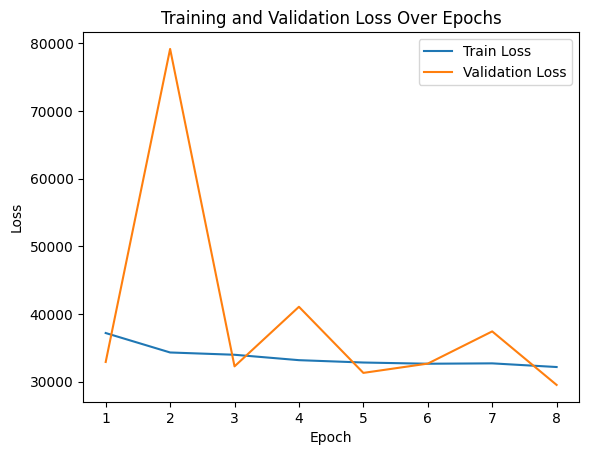

In [13]:
# Load the best model
checkpoint = torch.load(best_model_path) #'../saved_models/resized/'
model.load_state_dict(checkpoint['model_state_dict'])

# Load its history
history = checkpoint['history']
train_losses = history['train_losses']
val_losses = history['val_losses']

# Plot train and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [14]:
# Testing
model.eval()
test_loss = 0.0
predictions = []
ground_truths = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predictions.extend(outputs.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Calculate evaluation metrics
mse = mean_squared_error(ground_truths, predictions)
rmse = math.sqrt(mse)
r2 = r2_score(ground_truths, predictions)

# Print evaluation metrics
print("Test Loss (MAE): {:.0f}".format(test_loss))
print("Mean Squared Error (MSE): {:.0f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.0f}".format(rmse))
print("R-squared (R2): {:.3f}".format(r2))

Test Loss (MAE): 29326
Mean Squared Error (MSE): 1600075904
Root Mean Squared Error (RMSE): 40001
R-squared (R2): 0.140


In [17]:
np.std(predictions)

14477.469

In [18]:
predictions

[array([68568.375], dtype=float32),
 array([85183.02], dtype=float32),
 array([75346.34], dtype=float32),
 array([84325.81], dtype=float32),
 array([63264.707], dtype=float32),
 array([70252.48], dtype=float32),
 array([66788.266], dtype=float32),
 array([35730.688], dtype=float32),
 array([92354.13], dtype=float32),
 array([93458.55], dtype=float32),
 array([97185.56], dtype=float32),
 array([91167.65], dtype=float32),
 array([49112.395], dtype=float32),
 array([58310.508], dtype=float32),
 array([78073.2], dtype=float32),
 array([64042.52], dtype=float32),
 array([88935.99], dtype=float32),
 array([57797.74], dtype=float32),
 array([81556.76], dtype=float32),
 array([67642.945], dtype=float32),
 array([91317.98], dtype=float32),
 array([88453.62], dtype=float32),
 array([100600.2], dtype=float32),
 array([103538.38], dtype=float32),
 array([85668.38], dtype=float32),
 array([65958.56], dtype=float32),
 array([99381.46], dtype=float32),
 array([64746.094], dtype=float32),
 array([4791

In [120]:
## Method: create image patches

# create a training and validation dataset

# Define the path to the folder with the cropped images and their labels
data_folder = "../data/crops"

# Define the patch size for the image patches
patch_size = 512

# Define the transform to be applied to each image patch
transform = transforms.Compose([
    transforms.ToTensor()
])

class ImageDataset(Dataset):
    def __init__(self, data_folder, patch_size, transform=None):
        self.data_folder = data_folder
        self.patch_size = patch_size
        self.transform = transform
        
        # Get the list of image files and their corresponding labels
        self.image_files = []
        self.labels = []
        for filename in os.listdir(data_folder):
            if filename.endswith(".tif"):
                self.image_files.append(filename)
                label = int(filename.split("_")[3].replace(".tif", ""))  # Extract the label from the filename
                self.labels.append(label)
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load the image and convert to a PIL Image object
        image_path = os.path.join(self.data_folder, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        
        # Resize the image to a multiple of the patch size
        width, height = image.size
        new_width = self.patch_size * int(np.ceil(width / self.patch_size))
        new_height = self.patch_size * int(np.ceil(height / self.patch_size))
        image = image.resize((new_width, new_height))
        
        # Compute the number of patches in the x and y directions
        n_patches_x = int(new_width / self.patch_size)
        n_patches_y = int(new_height / self.patch_size)
        
        # Initialize a list to store the image patches
        patches = []
        
        # Loop over the patches and extract each one
        for j in range(n_patches_y):
            for i in range(n_patches_x):
                x0 = i * self.patch_size
                y0 = j * self.patch_size
                x1 = x0 + self.patch_size
                y1 = y0 + self.patch_size
                patch = image.crop((x0, y0, x1, y1))
                if self.transform:
                    patch = self.transform(patch)
                patches.append(patch)
        
        # Convert the list of patches to a tensor
        patches = torch.stack(patches)
        
        # Get the label for this image
        label = self.labels[idx]
        
        return patches, label

# Initialize a dataset object for the cropped images and their labels
dataset = ImageDataset(data_folder, patch_size, transform=transform)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

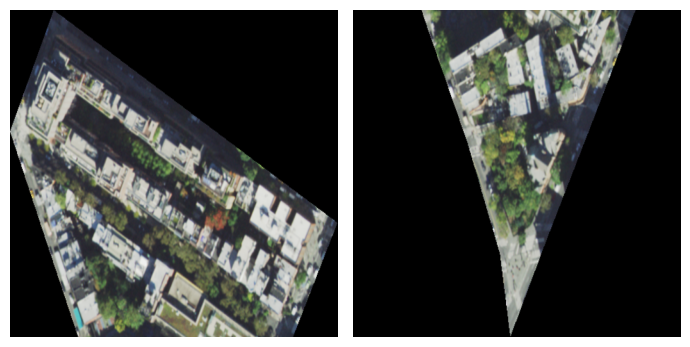

In [131]:
# Define a function to display a grid of images

def show_images(images):
    num_images = images.shape[0]
    num_cols = int(math.ceil(math.sqrt(num_images)))
    num_rows = int(math.ceil(num_images / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 7))
    
    # Handle cases when axes is a 2D array or a single Axes object
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        if i < num_images:
            image = images[i].permute(1, 2, 0).numpy()
            ax.imshow(image)
            ax.axis('off')
        else:
            # If there are more axes than images, hide the extra axes
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


# Get a batch of image patches from an image in the dataset
dis_images = train_dataset[1][0]

# Display the image patches
show_images(dis_images)


In [62]:
## Method: Autoencoder + regression on image patches

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
## Train autoencoder

# Initialize the autoencoder model
autoencoder = Autoencoder()

# Move the model to the GPU
device = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
autoencoder.to(device)

# Define the loss function and optimizer
encoder_criterion = nn.MSELoss()
encoder_optimizer = optim.Adam(autoencoder.parameters())

# Initialize variables for tracking validation loss and early stopping
best_loss = float('inf')
patience = 3
no_improvement_count = 0

# Train the autoencoder on the training dataset
for epoch in range(500):
    running_loss = 0.0
    for data in train_dataset:
        patches, labels = data
        # Move the data to the GPU and convert to float
        #patches = patches.to(device).float()
        encoder_optimizer.zero_grad()
        # Forward pass
        encoded, decoded = autoencoder(patches)
        # Compute the loss
        loss = encoder_criterion(decoded, patches)
        # Backward pass and optimization
        loss.backward()
        encoder_optimizer.step()
        running_loss += loss.item()

    # Validate the autoencoder on the validation dataset
    with torch.no_grad():
        val_loss = 0.0
        for val_data in val_dataset:
            val_patches, val_labels = val_data
            #val_patches = val_patches.to(device).float()
            val_encoded, val_decoded = autoencoder(val_patches)
            val_loss += encoder_criterion(val_decoded, val_patches).item()
        val_loss /= len(val_dataset)

        # Check if the validation loss has significantly improved
        if val_loss < 0.97*best_loss:
            best_loss = val_loss
            no_improvement_count = 0
            # Save the model at its lowest loss
            torch.save(autoencoder.state_dict(), f'../saved_models/autoencoder_{val_loss}.pt')
        else:
            no_improvement_count += 1

        # Print epoch results
        print(f"Epoch {epoch + 1}: Train loss={running_loss / len(train_dataset)}, Validation loss={val_loss}")

        # Check if early stopping criteria are met
        if no_improvement_count >= patience:
            print("< 3 percent improvement in validation loss for 3 epochs. Stopping training.")
            break

In [5]:
# Load a saved autoencoder
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('../saved_models/autoencoder_0.001780493468814121.pt'))

<All keys matched successfully>

In [10]:
# Define the downstream regression model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(8*28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = x.view(-1, 8*28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the regression model
regression_model = RegressionModel()

# Define the loss function and optimizer for regression
regression_criterion = nn.MSELoss()
regression_optimizer = optim.Adam(regression_model.parameters())

# Initialize empty lists to store encoded training data and labels
train_encoded = []
train_labels = []

# Encode the training dataset
print("Encoding training set...")
for data in train_dataset:
    patches, labels = data
    encoded, _ = autoencoder(patches)
    train_encoded.append(encoded)
    for i in range(data[0].shape[0]):
        train_labels.append(torch.tensor(labels))

# Concatenate the encoded training data and labels into tensors
train_encoded = torch.cat(train_encoded, dim=0)
train_labels = torch.stack(train_labels, dim=0)
train_labels = train_labels.float()

# Train the regression model on the encoded training dataset
print("Training regressor...")
for epoch in range(10):
    running_loss = 0.0
    regression_optimizer.zero_grad()
    for i in range(len(train_encoded)):
        encoded = train_encoded[i]
        label = train_labels[i]
        output = regression_model(encoded)
        loss = regression_criterion(output, label)
        loss.backward(retain_graph=True)
        running_loss += loss.item()
        regression_optimizer.step()
        regression_optimizer.zero_grad()
    print(f"Epoch {epoch + 1}: loss={running_loss / len(train_encoded)}")


# Encode the images in the validation dataset using the trained autoencoder
print("Validating...")
val_encoded = []
val_labels = []
for data in val_dataset:
    patches, labels = data
    encoded, _ = autoencoder(patches)
    val_encoded.append(encoded)
    val_labels.append(torch.tensor(labels))
val_encoded = torch.cat(val_encoded, dim=0)
val_labels = torch.stack(val_labels, dim=0)
val_labels = val_labels.float()

# Evaluate the regression model on the encoded validation dataset
with torch.no_grad():
    predictions = regression_model(val_encoded)
    validation_loss = regression_criterion(predictions, val_labels)
print(f"Validation loss: {validation_loss.item()}")

Encoding training set...
Training regressor...


/home/vida/emb9617/anaconda3/envs/ethan/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [10]:
## Method: vision transformer on image patches

# Setup and train the model
# Define the model architecture
class VisionTransformer(nn.Module):
    def __init__(self, num_patches, patch_dim, hidden_dim, num_heads, num_layers):
        super(VisionTransformer, self).__init__()

        # Define the input embedding layer
        self.input_embedding = nn.Linear(num_patches * patch_dim**2, hidden_dim)

        # Define the transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(hidden_dim, num_heads) for _ in range(num_layers)
        ])

        # Define the output layer
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x, num_patches=None):
        # Flatten the patches
        x = x.view(x.size(0), -1)

        # Embed the patches
        x = self.input_embedding(x)

        # Reshape to batch_size x max_num_patches x hidden_dim
        batch_size, _, hidden_dim = x.size()
        x = x.view(batch_size, -1, hidden_dim)

        # Remove the padded patches
        max_num_patches = x.size(1)
        if num_patches is not None:
            mask = torch.arange(max_num_patches).expand(len(num_patches), -1) < num_patches.unsqueeze(1)
            mask = mask.unsqueeze(-1).expand(-1, -1, hidden_dim)
            x = x[mask].view(batch_size, -1, hidden_dim)

        # Apply the transformer layers
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x)

        # Compute the output by averaging the patches
        x = x.mean(dim=1)

        # Apply the output layer
        x = self.output_layer(x)

        return x

# Define the vision transformer model
model = VisionTransformer(16, 224, 128, 4, 8)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

def collate_fn(batch):
    # stack the image patches and get the maximum number of patches in a single image
    max_patches = max([len(img_patches) for img_patches, _ in batch])
    stacked_imgs = []
    labels = []
    num_patches = []
    for img_patches, label in batch:
        stacked_imgs.append(img_patches)
        num_patches.append(len(img_patches))
        labels.append(label)
    stacked_imgs = pad_sequence(stacked_imgs, batch_first=True, padding_value=0)  # pad the tensors
    labels = torch.tensor(labels)
    num_patches = torch.tensor(num_patches)
    return stacked_imgs, labels, num_patches

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

# Define the number of training epochs
num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    for data, target, num_patches in train_loader:
        optimizer.zero_grad()
        output = model(data, num_patches)
        loss = criterion(output, target.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size
    train_loss /= len(train_loader.dataset)

    # Evaluate the model on the validation set
    val_loss = 0.0
    with torch.no_grad():
        for data, target, num_patches in val_loader:
            output = model(data, num_patches)
            loss = criterion(output, target.float().unsqueeze(1))
            val_loss += loss.item() * data.size
        val_loss /= len(val_loader.dataset)

    # Print the epoch, training loss, and validation loss
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")